In [1]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



C:\Users\prakhar\Anaconda32\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#It is used to convert the images into numpy array so that it can be trained for model. 
def drawing_to_np(drawing, shape=(28, 28)):
    # evaluates the drawing array
    drawing = eval(drawing)
    fig, ax = plt.subplots()
    # Close figure so it won't get displayed while transforming the set
    plt.close(fig)
    for x,y in drawing:
        ax.plot(x, y, marker='.')
        ax.axis('off')        
    fig.canvas.draw()
    # Convert images to numpy array
    np_drawing = np.array(fig.canvas.renderer._renderer)
    # Take only one channel
    np_drawing =np_drawing[:, :, 1]    
    # Normalize data
    np_drawing = np_drawing / 255.
    return cv2.resize(np_drawing, shape) # Resize array


def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')

    plt.xlabel('Epochs')

In [3]:
def plot_confusion_matrix(cnf_matrix, labels): 
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(20,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")

In [6]:
TRAIN_PATH = 'D:/train_simplified/'
TEST_PATH = 'D:/test_simplified.csv'
SUBMISSION_NAME = 'D:/ssubmission.csv'

In [7]:
files = os.listdir(TRAIN_PATH)
categories = [category.split('.')[0] for category in files]
print('Total number of categories: ',len(categories))
print('Few Example Categories',categories[0:5])

Total number of categories:  340
Few Example Categories ['airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration']


In [9]:
train = pd.DataFrame()
for file in os.listdir(TRAIN_PATH)[:6]:
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols=[1, 5], nrows=2000))
# Shuffle data
train = shuffle(train, random_state=123)
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=100)

In [10]:
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 0.001
N_CLASSES = train['word'].nunique()
HEIGHT = 28
WIDTH = 28
CHANNEL = 1


In [11]:
print('Train set shape: ', train.shape)
print('Train set features: %s' % train.columns.values)
print('Train number of label categories: %s' % N_CLASSES)
train.head()


Train set shape:  (12000, 2)
Train set features: ['drawing' 'word']
Train number of label categories: 6


,drawing,word
1744,"[[[16, 11, 15, 24, 36, 47, 58], [58, 44, 23, 6...",alarm clock
969,"[[[24, 25, 37, 78, 92, 100, 109, 107, 100, 53,...",ant
10,"[[[102, 63, 14, 2, 0, 9, 29, 51, 100, 142, 181...",airplane
1674,"[[[110, 105, 106, 109, 156, 168, 195, 213, 231...",airplane
398,"[[[112, 114, 103, 103, 110, 125, 128, 134, 139...",angel


In [12]:
#Fixing label
train['word'] = train['word'].replace(' ', '_', regex=True)
# Get labels and one-hot encode them.
classes_names = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)
# Transform drawing into numpy arrays
train['drawing_np'] = train['drawing'].apply(drawing_to_np)
# Reshape arrays
train_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in train['drawing_np'].values])

In [13]:
train.head()

,drawing,drawing_np
1744,"[[[16, 11, 15, 24, 36, 47, 58], [58, 44, 23, 6...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
969,"[[[24, 25, 37, 78, 92, 100, 109, 107, 100, 53,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
10,"[[[102, 63, 14, 2, 0, 9, 29, 51, 100, 142, 181...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1674,"[[[110, 105, 106, 109, 156, 168, 195, 213, 231...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
398,"[[[112, 114, 103, 103, 110, 125, 128, 134, 139...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [14]:
x_train, x_val, y_train, y_val = train_test_split(train_drawings, labels, test_size=0.2, random_state=1)

In [15]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation = "softmax"))

optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
print('Dataset size: %s' % train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: (%s, %s, %s)' % (HEIGHT, WIDTH, CHANNEL))
model.summary()

Dataset size: 12000
Epochs: 60
Learning rate: 0.001
Batch size: 64
Input dimension: (28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
______________________________________________

In [17]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Train on 9600 samples, validate on 2400 samples
Epoch 1/60
9600/9600 [==============================] - 45s 5ms/step - loss: 1.7935 - acc: 0.1591 - val_loss: 1.7919 - val_acc: 0.1642
Epoch 2/60
9600/9600 [==============================] - 44s 5ms/step - loss: 1.7921 - acc: 0.1643 - val_loss: 1.7910 - val_acc: 0.2225
Epoch 3/60
9600/9600 [==============================] - 44s 5ms/step - loss: 1.4972 - acc: 0.3946 - val_loss: 1.1638 - val_acc: 0.5737
Epoch 4/60
9600/9600 [==============================] - 44s 5ms/step - loss: 1.1657 - acc: 0.5623 - val_loss: 1.0469 - val_acc: 0.6271
Epoch 5/60
9600/9600 [==============================] - 44s 5ms/step - loss: 1.0463 - acc: 0.6168 - val_loss: 0.9622 - val_acc: 0.6558
Epoch 6/60
9600/9600 [==============================] - 44s 5ms/step - loss: 1.0048 - acc: 0.6373 - val_loss: 0.9324 - val_acc: 0.6754
Epoch 7/60
9600/9600 [==============================] - 44s 5ms/step - loss: 0.9600 - acc: 0.6527 - val_loss: 0.8848 - val_acc: 0.6892
Epoch 8

In [18]:
score = model.evaluate(x_val, y_val)
score

2400/2400 [==============================] - 4s 2ms/step


[0.7185744088888169, 0.7616666666666667]

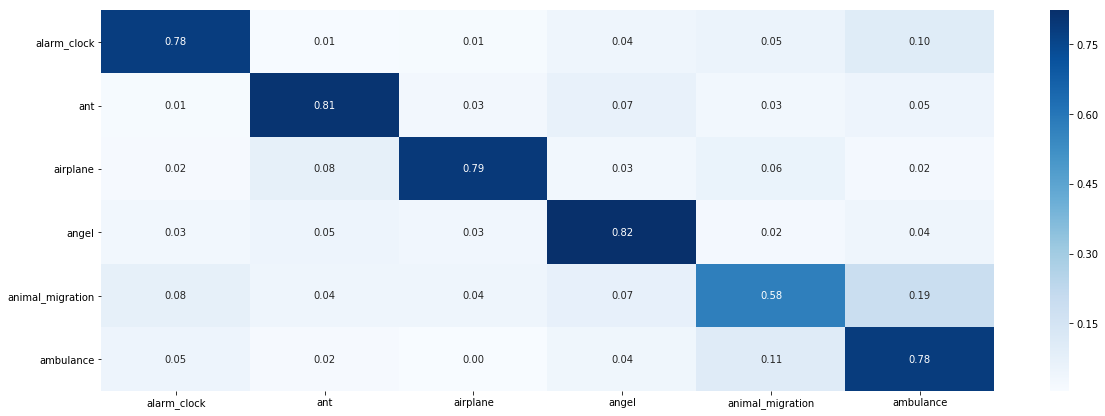

In [19]:
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), model.predict_classes(x_val))
plot_confusion_matrix(cnf_matrix, classes_names)



In [20]:
test['drawing_np'] = test['drawing'].apply(drawing_to_np)
# Reshape arrays
test_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in test['drawing_np'].values])

In [21]:
predictions = model.predict(test_drawings)
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (classes_names[pred[0]], classes_names[pred[1]], classes_names[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions



In [22]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

,key_id,word
0,9000003627287624,alarm_clock airplane ambulance
1,9000010688666847,angel alarm_clock airplane
2,9000023642890129,angel animal_migration ambulance
3,9000038588854897,ant ambulance animal_migration
4,9000052667981386,ambulance animal_migration alarm_clock
